In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [2]:
data = np.loadtxt('covtype.data', delimiter=',')
#data = np.loadtxt('covtype_7000.data', delimiter=',')

In [3]:
# Find the most common classes
count = Counter(data[:,54])
print(count.most_common(3))

[(2.0, 283301), (1.0, 211840), (3.0, 35754)]


In [4]:
for i in range(len(data[:,54])):
    if data[i,54] == 2:
        data[i,54] = 1
    else:
        data[i,54] = 0

In [5]:
print(data)
print(data.shape)

data_continuous = data[:,0:10]
d_s = StandardScaler()
d_n = d_s.fit_transform(data_continuous)

X_and_Y = np.hstack([d_n, data[:,10:56]])
print(X_and_Y)

[[  2.59600000e+03   5.10000000e+01   3.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.59000000e+03   5.60000000e+01   2.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.80400000e+03   1.39000000e+02   9.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 ..., 
 [  2.38600000e+03   1.59000000e+02   1.70000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.38400000e+03   1.70000000e+02   1.50000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.38300000e+03   1.65000000e+02   1.30000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
(581012, 55)
[[-1.29780509 -0.93515698 -1.48281978 ...,  0.          0.          0.        ]
 [-1.31923485 -0.89047967 -1.61636259 ...,  0.          0.          0.        ]
 [-0.5549068  -0.14883628 -0.68156292 ...,  0.          0.          1.        ]
 ..., 
 [-2.04784663  0.02987297  0.38677957 ...,  0.          0.  

In [6]:
# Divide data into training and testing sets

np.random.shuffle(X_and_Y)

# Try to predict the last column (the cover type, which is 7 types)
# NOTE: the largest number is "positive", while the other ones count as negative. This way it is a binary classification problem
X = X_and_Y[:5000,0:-1]
Y = X_and_Y[:5000,-1]
print(X.shape, Y.shape)

(5000, 54) (5000,)


In [7]:
X_train_val = X[:int(0.8*len(X))]
X_test      = X[int(0.8*len(X)):]
Y_train_val = Y[:int(0.8*len(Y))]
Y_test      = Y[int(0.8*len(Y)):]
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(4000, 54) (1000, 54) (4000,) (1000,)


In [8]:
# SVM process

# linear
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='linear')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]   
params = {"C": C_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([   1.00952916,    1.12257786,    1.1566009 ,    0.9793026 ,
           1.01960783,    0.92224641,    0.90493889,    1.16870766,
           2.99982548,   16.79109597,  138.70822744]),
 'mean_score_time': array([ 0.16251512,  0.17063155,  0.18262892,  0.164116  ,  0.17722874,
         0.14030046,  0.11928453,  0.11708283,  0.098175  ,  0.09226503,
         0.08826938]),
 'mean_test_score': array([ 0.5195 ,  0.5195 ,  0.5195 ,  0.5195 ,  0.61175,  0.70775,
         0.748  ,  0.76175,  0.762  ,  0.7625 ,  0.76175]),
 'mean_train_score': array([ 0.5195    ,  0.5195    ,  0.5195    ,  0.5195    ,  0.61312485,
         0.7123132 ,  0.75406281,  0.76650029,  0.76737516,  0.76718758,
         0.76718768]),
 'param_C': masked_array(data = [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1.0 10.0 100.0 1000.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1e-07},
  {'C': 1e-06},
  {'C': 1e-05}

In [9]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 100.0}
0.756


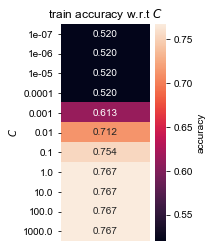

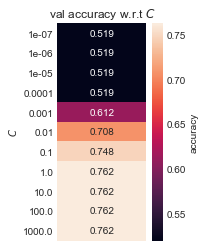

In [10]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
results = GSR.cv_results_

train_acc = np.matrix(results.get("mean_train_score")).T
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = np.matrix(results.get("mean_test_score")).T
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [11]:
def convert_to_gamma(radial_width):
    converted = [0]*len(radial_width)
    for i in range(len(radial_width)):
        gamma = 1/(2*(radial_width[i]**2))
        converted[i] = gamma
    return converted

radial_width = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
gamma_list = convert_to_gamma(radial_width)

# SVM process

# rbf
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='rbf')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]
params = {"C": C_list, "gamma": gamma_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([ 1.45880876,  1.60414457,  1.62376256,  1.65909839,  2.55503192,
         1.30258794,  1.28123221,  1.21997108,  1.4930769 ,  1.39709816,
         1.67351584,  1.83262105,  2.73584776,  1.40949664,  1.30679426,
         1.23083005,  1.52612906,  1.35487251,  1.39748802,  1.54971137,
         2.63104544,  1.42532506,  1.2508956 ,  1.37361107,  1.42206402,
         1.57393861,  1.48762331,  1.48186736,  2.61779919,  1.48355532,
         1.29011626,  1.35495973,  1.74414811,  1.64542418,  1.58046856,
         1.84547076,  2.71797557,  1.28721085,  1.23579068,  1.38193169,
         1.65557137,  1.67864871,  1.99662223,  1.65799623,  2.93973136,
         1.68538189,  1.51491027,  1.24229259,  1.69556808,  1.94728031,
         1.5796165 ,  1.97062645,  3.09419279,  1.66388016,  1.71331668,
         1.32283964,  1.69134636,  1.55108027,  1.56484504,  1.65964818,
         2.72885871,  1.60488443,  1.1917439 ,  0.88193979,  1.59544773,
         1.55730371,  1.59793296, 

In [12]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 1.0, 'gamma': 0.5}
0.802


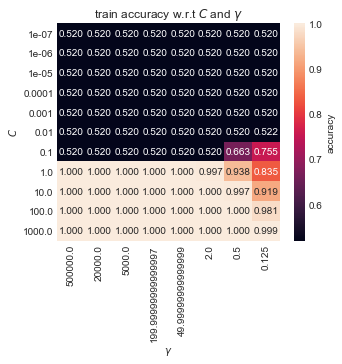

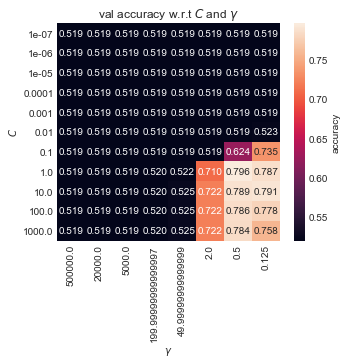

In [13]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()   

train_acc = GSR.cv_results_['mean_train_score'].reshape(11,8)
draw_heatmap_RBF(train_acc, 'train accuracy', gamma_list, C_list)

val_acc = GSR.cv_results_['mean_test_score'].reshape(11,8)
draw_heatmap_RBF(val_acc, 'val accuracy',gamma_list, C_list)

In [14]:
# KNN
k_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#k_list = [1,5,8]
params = {"n_neighbors": k_list}
knn = KNeighborsClassifier(n_neighbors=26)
kgs=GridSearchCV(knn, params)
knn.fit(X_train_val, Y_train_val)
knn.predict(X_test)

array([ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1

In [15]:
# compute accuracy
test_acc = np.sum(knn.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.775


In [16]:
# Random Forest
rf = RandomForestClassifier(n_estimators=1024, random_state=0, n_jobs=4)
rf.fit(X_train_val, Y_train_val)
rf.predict(X_test)

array([ 0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1

In [17]:
# compute accuracy
test_acc = np.sum(rf.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.82
